##### Face Attributes Recognition with MobileNet (v2 / v3)


In [ ]:
!pip install -q kaggle
!pip install facenet-pytorch

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = r'/content/drive/MyDrive/Nhom1_Py/Dataset'
os.listdir(path)

['utkface-new', 'fer2013', 'sample_img', 'ex_mobilenet', 'test_vgg']

In [ ]:
# 2. Import thư viện
import os, glob
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !mkdir -p ~/.kaggle

In [ ]:
# !mv kaggle.json ~/.kaggle/

In [ ]:
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d msambare/fer2013 -p "/content/drive/MyDrive/Colab Notebooks/dataset" --force

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/dataset/fer2013.zip" -d "/content/drive/MyDrive/Colab Notebooks/dataset/fer2013"

In [ ]:
# !kaggle datasets download -d jangedoo/utkface-new -p "/content/drive/MyDrive/Colab Notebooks/dataset" --force

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/dataset/utkface-new.zip" -d "/content/drive/MyDrive/Colab Notebooks/dataset/utkface-new"

## 3. Dataset UTKFace

Tên file: `age_gender_race_....jpg`
- age: 0–116
- gender: 0=male, 1=female
- race: 0=White, 1=Black, 2=Asian, 3=Indian, 4=Others

Em sẽ map age thành 5 nhóm để dễ train.

In [ ]:
import os
import glob
from PIL import Image
from torch.utils.data import Dataset

def age_to_group5(age: int) -> int:
    """
    Chia lại nhóm tuổi tối ưu hơn:
    0: 0-14  (Trẻ em)
    1: 15-25 (Thanh thiếu niên - Quan trọng để fix lỗi nhận 19t thành 0)
    2: 26-40 (Thanh niên / Trung niên sớm)
    3: 41-60 (Trung niên)
    4: 61+   (Người cao tuổi)
    """
    if age <= 14:
        return 0
    elif age <= 25:
        return 1
    elif age <= 40:
        return 2
    elif age <= 60:
        return 3
    else:
        return 4

class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []

        # Lấy tất cả ảnh JPG/JPEG/PNG
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_paths.extend(glob.glob(os.path.join(root_dir, ext)))
        self.image_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path)
        parts = filename.split('_')

        age = int(parts[0])
        gender = int(parts[1])  # 0: male, 1: female
        race = int(parts[2])    # 0-4

        age_cls = age_to_group5(age)

        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        return {
            'image': img,
            'age_cls': age_cls,
            'gender': gender,
            'race': race
        }

In [ ]:
# 3.1. Transform + DataLoader (Đã sửa để không bị méo ảnh)

train_tfms = T.Compose([
    T.Resize(256),              # Resize cạnh nhỏ nhất lên 256
    T.RandomCrop(224),          # Cắt ngẫu nhiên 224x224
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),          # Cắt chính giữa 224x224
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = "/content/drive/MyDrive/Nhom1_Py/Dataset/utkface-new/train"
val_dir = "/content/drive/MyDrive/Nhom1_Py/Dataset/utkface-new/val"

if os.path.exists(train_dir):
    train_ds = UTKFaceDataset(train_dir, transform=train_tfms)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
else:
    train_ds = None
    train_loader = None

if os.path.exists(val_dir):
    val_ds = UTKFaceDataset(val_dir, transform=val_tfms)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
else:
    val_ds = None
    val_loader = None

print("Đã cập nhật Transform chuẩn (Resize 256 -> Crop 224)")

Đã cập nhật Transform chuẩn (Resize 256 -> Crop 224)


## 4. Xây dựng MobileNet Multi-head

Mình sẽ viết 1 class cho **MobileNetV2**, sau đó 1 class gần y hệt cho **MobileNetV3-Small**. Bạn muốn dùng cái nào thì khởi tạo cái đó.

Các head:
- Age: 5 lớp
- Gender: 2 lớp
- Race: 5 lớp


In [ ]:
# Thay thế cell class MobileNetV2MultiHead cũ bằng cell này
class MobileNetV2MultiHead(nn.Module):
    def __init__(self, num_age=5, num_gender=2, num_race=5):
        super().__init__()
        base = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features
        last_channel = base.last_channel

        self.pool = nn.AdaptiveAvgPool2d(1)

        # Thêm Dropout vào đây để chống overfitting
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5), # Tắt ngẫu nhiên 50% nơ-ron khi train
            nn.Linear(last_channel, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5)  # Thêm một lớp nữa cho chắc
        )

        self.age_head = nn.Linear(512, num_age)
        self.gender_head = nn.Linear(512, num_gender)
        self.race_head = nn.Linear(512, num_race)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return self.age_head(x), self.gender_head(x), self.race_head(x)

model = MobileNetV2MultiHead().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 74.4MB/s]


## 5. Hàm train / eval 5 epoch

Giống mấy notebook trước: tổng loss = loss_age + loss_gender + loss_race.


In [ ]:
def train_one_epoch(model, loader, optimizer, ce_age, ce_gender, ce_race):
    model.train()
    run_loss = 0.0
    for batch in loader:
        imgs = batch['image'].to(device)
        age = batch['age_cls'].to(device)
        gender = batch['gender'].to(device)
        race = batch['race'].to(device)

        optimizer.zero_grad()
        age_logits, gender_logits, race_logits = model(imgs)
        loss_age = ce_age(age_logits, age)
        loss_gender = ce_gender(gender_logits, gender)
        loss_race = ce_race(race_logits, race)
        loss = loss_age + loss_gender + loss_race
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * imgs.size(0)
    return run_loss / len(loader.dataset)

In [ ]:
@torch.no_grad()
def eval_one_epoch(model, loader, ce_age, ce_gender, ce_race):
    model.eval()
    total = 0
    run_loss = 0.0
    correct_age = 0
    correct_gender = 0
    correct_race = 0
    for batch in loader:
        imgs = batch['image'].to(device)
        age = batch['age_cls'].to(device)
        gender = batch['gender'].to(device)
        race = batch['race'].to(device)
        age_logits, gender_logits, race_logits = model(imgs)
        loss_age = ce_age(age_logits, age)
        loss_gender = ce_gender(gender_logits, gender)
        loss_race = ce_race(race_logits, race)
        loss = loss_age + loss_gender + loss_race
        run_loss += loss.item() * imgs.size(0)

        _, age_pred = age_logits.max(1)
        _, gender_pred = gender_logits.max(1)
        _, race_pred = race_logits.max(1)
        correct_age += (age_pred == age).sum().item()
        correct_gender += (gender_pred == gender).sum().item()
        correct_race += (race_pred == race).sum().item()
        total += imgs.size(0)
    avg_loss = run_loss / len(loader.dataset)
    age_acc = correct_age / total
    gender_acc = correct_gender / total
    race_acc = correct_race / total
    return avg_loss, age_acc, gender_acc, race_acc

In [ ]:
# 6. Train loop (Đã tinh chỉnh Class Weights cho người Châu Á)
num_epochs = 1  # Tăng lên 15 để model học kỹ hơn
import torch

# --- TRỌNG SỐ QUAN TRỌNG (CHÌA KHÓA ĐỂ NHẬN DIỆN ĐÚNG CHỦNG TỘC) ---
# Race 0: White, 1: Black, 2: Asian, 3: Indian, 4: Others
# Do dữ liệu Asian rất ít, ta phải phạt model gấp 5 lần nếu đoán sai Asian
race_weights = torch.tensor([1.0, 1.5, 5.0, 2.0, 1.5]).to(device)

# Age: 0-14, 15-25, 26-40, 41-60, 61+
# Phạt nặng nếu đoán sai nhóm 15-25 (nhóm tuổi của bạn) và nhóm già
age_weights = torch.tensor([0.5, 2.5, 1.5, 1.5, 2.0]).to(device)

# Áp dụng weights
ce_age = nn.CrossEntropyLoss(weight=age_weights)
ce_gender = nn.CrossEntropyLoss()
ce_race = nn.CrossEntropyLoss(weight=race_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # Giảm LR một chút để học chậm nhưng chắc

best_val_loss = float('inf')

if train_loader is not None and val_loader is not None:
    print("Bắt đầu training...")
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, ce_age, ce_gender, ce_race)
        val_loss, age_acc, gender_acc, race_acc = eval_one_epoch(model, val_loader, ce_age, ce_gender, ce_race)

        print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_loss:.4f} | Age Acc: {age_acc:.1%} | Gender Acc: {gender_acc:.1%} | Race Acc: {race_acc:.1%}")

        # Lưu model ngay khi thấy loss giảm
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/MyDrive/Nhom1_Py/mobilenet_multihead_best.pth")
            print(" Đã lưu model tốt nhất!")
else:
    print("Chưa load được dữ liệu train_loader!")

Bắt đầu training...
Epoch 1/1 | Val Loss: 2.0884 | Age Acc: 60.7% | Gender Acc: 82.3% | Race Acc: 66.5%
 Đã lưu model tốt nhất!


In [ ]:
!cp "checkpoints/mobilenet_multihead_best.pth" "/content/drive/MyDrive/Nhom1_Py/"

cp: cannot stat 'checkpoints/mobilenet_multihead_best.pth': No such file or directory


In [ ]:
import torch
from PIL import Image
import os
from torchvision import transforms

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- ĐỊNH NGHĨA MODEL Y HỆT LÚC TRAIN ---
class MobileNetV2MultiHead(nn.Module):
    def __init__(self, num_age=5, num_gender=2, num_race=5):
        super().__init__()
        base = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = base.features
        last_channel = base.last_channel
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Cấu trúc có Dropout (Lý do gây lỗi cũ là do thiếu cái này)
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(last_channel, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )

        self.age_head = nn.Linear(512, num_age)
        self.gender_head = nn.Linear(512, num_gender)
        self.race_head = nn.Linear(512, num_race)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return self.age_head(x), self.gender_head(x), self.race_head(x)

# --- KHỞI TẠO VÀ LOAD ---
model = MobileNetV2MultiHead().to(device)

checkpoint_path = "/content/drive/MyDrive/Nhom1_Py/mobilenet_multihead_best.pth"

if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    print("Load model thành công! Không còn lỗi mismatch key.")
else:
    print("Chưa tìm thấy file .pth! Bạn nhớ chạy Cell Training (Bước 2) trước nhé.")

Load model thành công! Không còn lỗi mismatch key.


In [ ]:
# ---------------------------------------------------------
# PHẦN DỰ ĐOÁN THÔNG MINH (DÙNG MTCNN ĐỂ CẮT MẶT)
# ---------------------------------------------------------
from facenet_pytorch import MTCNN
import torch
from PIL import Image

# 1. Khởi tạo công cụ dò tìm khuôn mặt
mtcnn = MTCNN(image_size=224, margin=20, keep_all=False, device=device)

# 2. Định nghĩa lại transform chuẩn hóa (giống lúc validate)
from torchvision import transforms
normalize_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_smart(img_path):
    img = Image.open(img_path).convert("RGB")

    # Bước 1: Dùng MTCNN để cắt khuôn mặt và resize về 224x224
    # save_path=None nghĩa là không lưu file cắt ra đĩa, chỉ lấy tensor
    face_img = mtcnn(img, save_path=None)

    if face_img is None:
        print(f"Không tìm thấy khuôn mặt trong ảnh {os.path.basename(img_path)}")
        return None, None, None

    # Bước 2: Chuẩn hóa (Normalize) pixel giống ImageNet
    # face_img từ MTCNN đã là tensor range [0..1] hoặc [-1..1] tùy config
    # Cách an toàn nhất để khớp với model train là chuyển về PIL rồi qua transform
    face_pil = transforms.ToPILImage()(face_img)
    input_tensor = normalize_tfms(face_pil).unsqueeze(0).to(device)

    # Bước 3: Đưa vào model
    model.eval()
    with torch.no_grad():
        age_logits, gender_logits, race_logits = model(input_tensor)

    age_pred = torch.argmax(age_logits, dim=1).item()
    gender_pred = torch.argmax(gender_logits, dim=1).item()
    race_pred = torch.argmax(race_logits, dim=1).item()

    return age_pred, gender_pred, race_pred

print("Đã khởi tạo xong hệ thống Predict thông minh với MTCNN")

Đã khởi tạo xong hệ thống Predict thông minh với MTCNN


KẾT QUẢ PHÂN TÍCH HÌNH ẢNH:



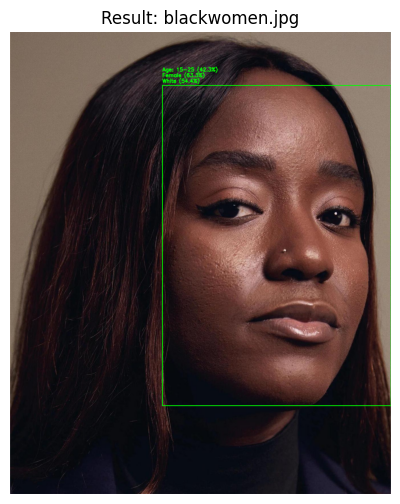

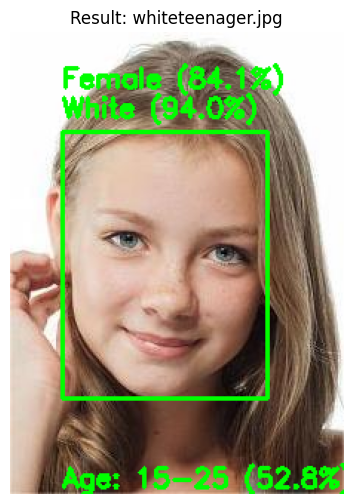

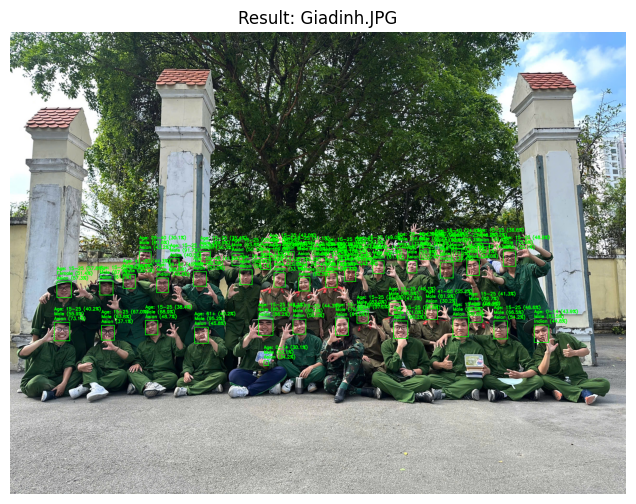

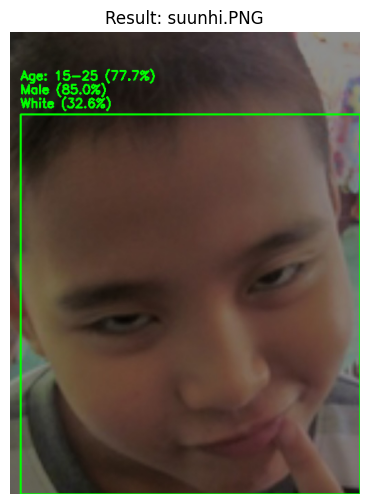

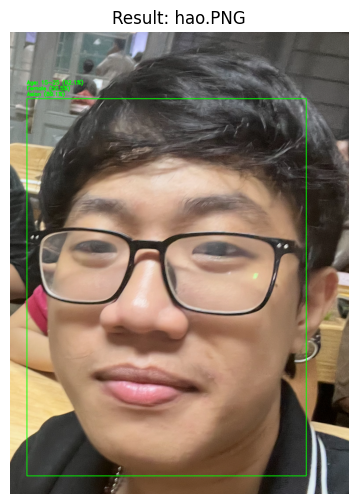

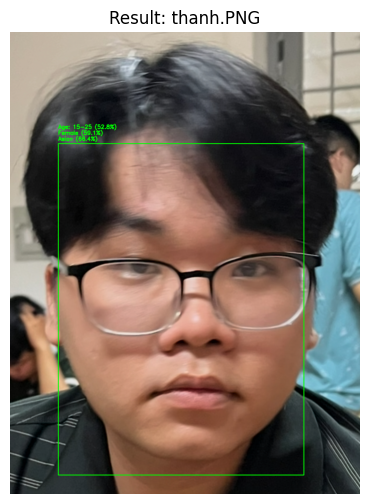

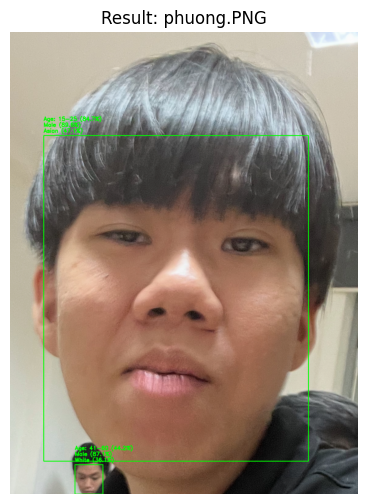

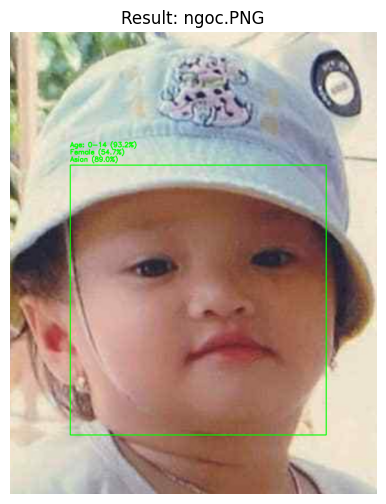

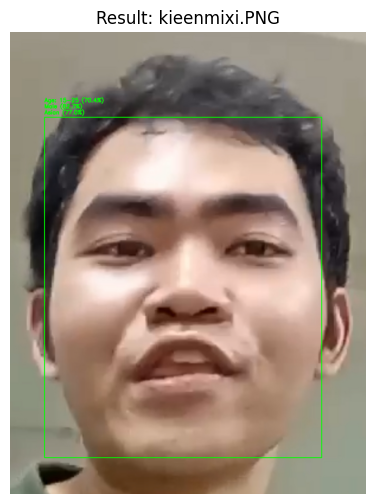

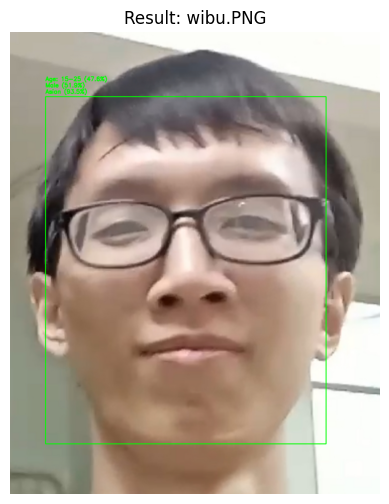

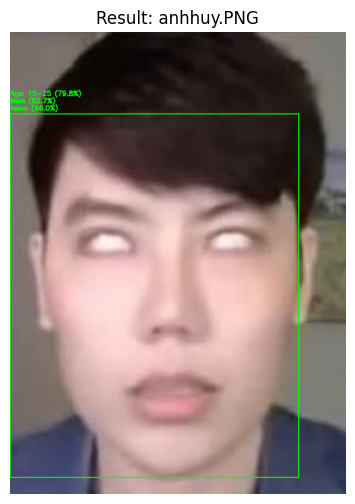

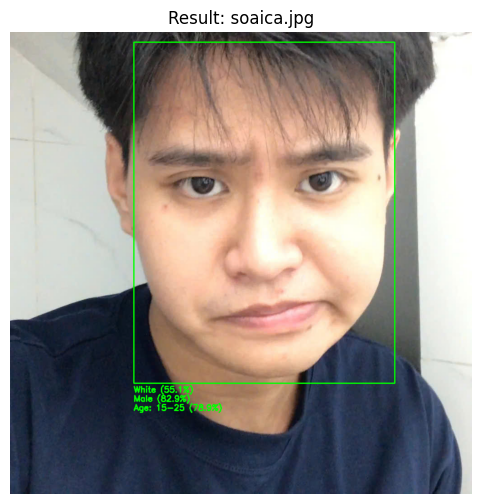

In [ ]:
# ------------------------------------------------------------------
# CELL NÀY THAY THẾ CHO CELL TEST CUỐI CÙNG CỦA BẠN
# ------------------------------------------------------------------
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

# Các nhãn hiển thị
age_labels = ["0-14", "15-25", "26-40", "41-60", "61+"]
gender_labels = ["Male", "Female"]
race_labels = ["White", "Black", "Asian", "Indian", "Others"]

# Transform chuẩn hóa cho đầu vào model (sau khi đã cắt mặt)
val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def visualize_prediction(img_path, model):
    # 1. Đọc ảnh gốc
    img = cv2.imread(img_path)
    if img is None:
        print(f"Không đọc được ảnh: {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển sang RGB để hiển thị đúng màu
    img_pil = Image.fromarray(img_rgb)

    # 2. Dùng MTCNN để lấy tọa độ khung hình (Bounding Box)
    # detect trả về tọa độ các khuôn mặt (boxes) và điểm xác suất (probs)
    boxes, _ = mtcnn.detect(img_pil)

    if boxes is not None:
        for box in boxes:
            # Lấy tọa độ
            x1, y1, x2, y2 = [int(b) for b in box]

            # Cắt mặt ra để đưa vào model dự đoán
            # Lưu ý: cần xử lý giới hạn biên để không bị lỗi index
            h, w, _ = img_rgb.shape
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)

            face_img = img_rgb[y1:y2, x1:x2]

            # Nếu mặt cắt ra quá nhỏ (do nhiễu), bỏ qua
            if face_img.size == 0: continue

            # Chuẩn hóa và đưa vào model
            input_tensor = val_tfms(face_img).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                age_logits, gender_logits, race_logits = model(input_tensor)

                # --- TÍNH TOÁN XÁC SUẤT (%) ---
                # Softmax giúp chuyển logits thành tổng = 1 (100%)
                age_probs = F.softmax(age_logits, dim=1)
                gender_probs = F.softmax(gender_logits, dim=1)
                race_probs = F.softmax(race_logits, dim=1)

                # Lấy class có % cao nhất
                age_conf, age_pred = torch.max(age_probs, 1)
                gender_conf, gender_pred = torch.max(gender_probs, 1)
                race_conf, race_pred = torch.max(race_probs, 1)

            # --- TẠO NHÃN HIỂN THỊ ---
            # Ví dụ: Asian (98%)
            text_race = f"{race_labels[race_pred.item()]} ({race_conf.item()*100:.1f}%)"
            text_age = f"Age: {age_labels[age_pred.item()]} ({age_conf.item()*100:.1f}%)"
            text_gender = f"{gender_labels[gender_pred.item()]} ({gender_conf.item()*100:.1f}%)"

            # --- VẼ LÊN ẢNH ---
            # Vẽ khung chữ nhật màu xanh lá (Green)
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Vẽ nền đen cho chữ dễ đọc
            font_scale = 0.6
            thickness = 2
            # Tính toán vị trí để in 3 dòng chữ không bị đè lên nhau
            lines = [text_race, text_gender, text_age]
            for i, line in enumerate(lines):
                y_pos = y1 - 10 - (i * 20) # Xếp chồng lên trên đầu
                if y_pos < 20: y_pos = y2 + 20 + (i * 20) # Nếu hết chỗ ở trên thì vẽ xuống dưới

                cv2.putText(img_rgb, line, (x1, y_pos),
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

    # 3. Hiển thị ảnh bằng Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis('off') # Tắt trục tọa độ cho đẹp
    plt.title(f"Result: {os.path.basename(img_path)}")
    plt.show()

# --- CHẠY VÒNG LẶP TEST ---
test_dir = "/content/drive/MyDrive/Nhom1_Py/Dataset/ex_mobilenet"

if os.path.exists(test_dir):
    print("KẾT QUẢ PHÂN TÍCH HÌNH ẢNH:\n")
    for filename in os.listdir(test_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(test_dir, filename)
            visualize_prediction(img_path, model)
else:
    print("Không tìm thấy thư mục test")